# EOPFZARR Driver with rioxarray Integration

This notebook demonstrates how to use the EOPFZARR GDAL driver with rioxarray to work with EOPF Zarr datasets.

## Overview

- **EOPFZARR Driver**: Custom GDAL driver for reading EOPF (Earth Observation Processing Framework) Zarr datasets
- **rioxarray**: Extension of xarray that adds geospatial capabilities using rasterio/GDAL
- **Integration**: Seamlessly read EOPF Zarr datasets with full geospatial support

## Key Features

✅ Open EOPF Zarr subdatasets with `rioxarray.open_rasterio()`  
✅ Automatic CRS (Coordinate Reference System) handling     
✅ Spatial bounds and transformations   
✅ Lazy loading with Dask for efficient memory usage    
✅ Full xarray functionality (slicing, computations, plotting)  

## Important Note

⚠️ **Always open specific subdatasets, not the root dataset!**

When opening the root dataset with rioxarray, it will eagerly load ALL subdatasets (123 for Sentinel-3 OLCI), which is slow. This is rioxarray's design, not an EOPFZARR limitation.

## 1. Setup and Imports

In [1]:
# Import required libraries
import rioxarray
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal
import time

# Enable GDAL exceptions for better error messages
gdal.UseExceptions()

print("✅ Imports successful!")
print(f"xarray version: {xr.__version__}")
print(f"GDAL version: {gdal.__version__}")

✅ Imports successful!
xarray version: 2025.4.0
GDAL version: 3.11.1


## 2. Test Dataset

We'll use a Sentinel-3 OLCI Level-1 EFR dataset from EODC (European Open Data Cube).

**Note:** We use the `EOPFZARR:` driver prefix (not `ZARR:`) to ensure our custom driver handles the dataset with proper subdataset support.

In [8]:
# Enable GDAL exceptions
gdal.UseExceptions()

# Helper function for eopfzarr paths (remote access)
def eopfzarr_path(url, subdataset=None):
    base = f'EOPFZARR:"/vsicurl/{url}"'
    return f'{base}:{subdataset}' if subdataset else base

# Sample URLs for Sentinel-3 products
olci_l1_efr_url = 'https://objects.eodc.eu/e05ab01a9d56408d82ac32d69a5aae2a:202508-s03olcefr/19/products/cpm_v256/S3B_OL_1_EFR____20250819T074058_20250819T074358_20250819T092155_0179_110_106_3420_ESA_O_NR_004.zarr'

## 3. List Available Subdatasets

First, let's see what subdatasets are available using GDAL.

In [9]:
# Open the root dataset to list subdatasets
ds = gdal.Open(eopfzarr_path(olci_l1_efr_url))
print(f"Driver: {ds.GetDriver().ShortName}")
print(f"Projection (CRS): {ds.GetProjection()}")
print(f"GeoTransform: {ds.GetGeoTransform()}")
subdatasets = ds.GetMetadata('SUBDATASETS')

print(f"Total subdatasets: {len(subdatasets) // 2}\n")

# Show first 10 subdatasets
print("First 10 subdatasets:")
print("=" * 80)
for i in range(0, min(20, len(subdatasets)), 2):
    name_key = f'SUBDATASET_{i//2 + 1}_NAME'
    desc_key = f'SUBDATASET_{i//2 + 1}_DESC'
    if name_key in subdatasets:
        print(f"{i//2 + 1}. {subdatasets[name_key]}")
        print(f"   Description: {subdatasets[desc_key]}")
        print()

ds = None  # Close dataset

Driver: EOPFZARR
Projection (CRS): GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
GeoTransform: (10.0, 0.009765625, 0.0, 45.0, 0.0, -0.009765625)
Total subdatasets: 123

First 10 subdatasets:
1. EOPFZARR:"/vsicurl/https://objects.eodc.eu/e05ab01a9d56408d82ac32d69a5aae2a:202508-s03olcefr/19/products/cpm_v256/S3B_OL_1_EFR____20250819T074058_20250819T074358_20250819T092155_0179_110_106_3420_ESA_O_NR_004.zarr":/conditions/geometry/latitude
   Description: [4091x77] /conditions/geometry/latitude (Float64)

2. EOPFZARR:"/vsicurl/https://objects.eodc.eu/e05ab01a9d56408d82ac32d69a5aae2a:202508-s03olcefr/19/products/cpm_v256/S3B_OL_1_EFR____20250819T074058_20250819T074358_20250819T092155_0179_110_106_3420_ESA_O_NR_004.zarr":/conditions/geometr

## 4. Open a Subdataset with rioxarray

Let's open a specific subdataset - the radiance measurement for Ocean and Land Colour Instrument (OLCI) band 1.

In [10]:
# Define the subdataset path
subdataset = f'EOPFZARR:"/vsicurl/{olci_l1_efr_url}":/measurements/oa01_radiance'

print(f"Opening: {subdataset}")
print("\nThis may take a few seconds...")

# Open with rioxarray
start_time = time.time()
data = rioxarray.open_rasterio(subdataset, chunks='auto')
elapsed = time.time() - start_time

print(f"\n✅ Opened successfully in {elapsed:.2f} seconds!")
print(f"\nData type: {type(data)}")
print(f"Shape: {data.shape}")
print(f"Dimensions: {data.dims}")

Opening: EOPFZARR:"/vsicurl/https://objects.eodc.eu/e05ab01a9d56408d82ac32d69a5aae2a:202508-s03olcefr/19/products/cpm_v256/S3B_OL_1_EFR____20250819T074058_20250819T074358_20250819T092155_0179_110_106_3420_ESA_O_NR_004.zarr":/measurements/oa01_radiance

This may take a few seconds...

✅ Opened successfully in 0.36 seconds!

Data type: <class 'xarray.core.dataarray.DataArray'>
Shape: (1, 4091, 4865)
Dimensions: ('band', 'y', 'x')

✅ Opened successfully in 0.36 seconds!

Data type: <class 'xarray.core.dataarray.DataArray'>
Shape: (1, 4091, 4865)
Dimensions: ('band', 'y', 'x')


## 5. Inspect the DataArray

Let's examine the xarray DataArray structure and metadata.

In [11]:
# Display the full DataArray
print("DataArray Structure:")
print("=" * 80)
print(data)
print("\n" + "=" * 80)

DataArray Structure:
<xarray.DataArray (band: 1, y: 4091, x: 4865)> Size: 80MB
dask.array<open_rasterio-b3713eee5dbcd8fd34ac305c8fba9500<this-array>, shape=(1, 4091, 4865), dtype=float32, chunksize=(1, 4091, 4865), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int32 4B 1
  * x            (x) float64 39kB 10.0 10.0 10.0 10.0 ... 15.0 15.0 15.0 15.0
  * y            (y) float64 33kB 45.0 45.0 45.0 45.0 ... 40.0 40.0 40.0 40.0
    spatial_ref  int32 4B 0
Attributes: (12/21)
    SUBDATASET_PATH:     /measurements/oa01_radiance
    EOPF_PRODUCT:        YES
    spatial_ref:         GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6...
    EPSG:                4326
    proj:                epsg=4326
    geospatial_lon_min:  10.0
    ...                  ...
    valid_max:           65534
    valid_min:           0
    _FillValue:          nan
    scale_factor:        1.0
    add_offset:          0.0
    units:               mW.m-2.sr-1.nm-1



## 6. Geospatial Information

One of the key benefits of using rioxarray is automatic geospatial metadata handling.

In [12]:
# Coordinate Reference System
print("Coordinate Reference System (CRS):")
print(f"  {data.rio.crs}")
print()

# Spatial bounds
print("Spatial Bounds:")
bounds = data.rio.bounds()
print(f"  Left:   {bounds[0]:.4f}")
print(f"  Bottom: {bounds[1]:.4f}")
print(f"  Right:  {bounds[2]:.4f}")
print(f"  Top:    {bounds[3]:.4f}")
print()

# Spatial resolution
print("Spatial Resolution:")
resolution = data.rio.resolution()
print(f"  X: {resolution[0]:.6f}")
print(f"  Y: {resolution[1]:.6f}")
print()

# Transform
print("Affine Transform:")
print(f"  {data.rio.transform()}")

Coordinate Reference System (CRS):
  EPSG:4326

Spatial Bounds:
  Left:   10.0000
  Bottom: 40.0000
  Right:  15.0000
  Top:    45.0000

Spatial Resolution:
  X: 0.001028
  Y: -0.001222

Affine Transform:
  | 0.00, 0.00, 10.00|
| 0.00,-0.00, 45.00|
| 0.00, 0.00, 1.00|


## 7. Data Access and Slicing

With xarray, we can easily slice and access data using coordinates or indices.

In [13]:
# Get a subset of the data
subset = data[0, 1000:1100, 2000:2100]

print("Subset shape:", subset.shape)
print("\nSubset values (first 5x5):")
print(subset[:5, :5].values)
print()

# Compute statistics on the subset
print("Statistics:")
print(f"  Min:  {float(subset.min()):.4f}")
print(f"  Max:  {float(subset.max()):.4f}")
print(f"  Mean: {float(subset.mean()):.4f}")
print(f"  Std:  {float(subset.std()):.4f}")

Subset shape: (100, 100)

Subset values (first 5x5):
[[58.6301   58.34377  58.34377  58.452847 58.534657]
 [58.09834  58.18015  58.18015  58.111973 58.480118]
 [58.234688 58.166515 58.166515 57.98926  58.34377 ]
 [58.425575 57.975624 57.975624 58.221054 58.398308]
 [58.207417 58.111973 58.111973 58.166515 58.166515]]

Statistics:
[[58.6301   58.34377  58.34377  58.452847 58.534657]
 [58.09834  58.18015  58.18015  58.111973 58.480118]
 [58.234688 58.166515 58.166515 57.98926  58.34377 ]
 [58.425575 57.975624 57.975624 58.221054 58.398308]
 [58.207417 58.111973 58.111973 58.166515 58.166515]]

Statistics:
  Min:  55.3441
  Min:  55.3441
  Max:  60.2390
  Max:  60.2390
  Mean: 57.6901
  Mean: 57.6901
  Std:  0.7892
  Std:  0.7892


## 8. Data Visualization

Let's visualize a subset of the radiance data.

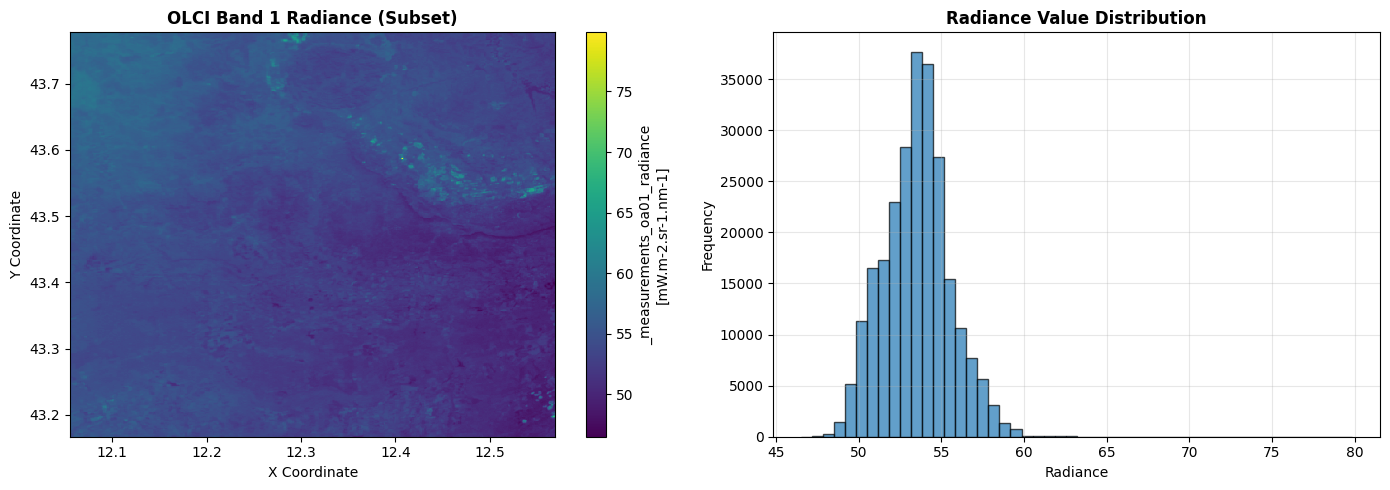

✅ Visualization complete!


In [14]:
# Create a larger subset for visualization
viz_subset = data[0, 1000:1500, 2000:2500]

# Create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Data
im1 = viz_subset.plot(ax=ax1, cmap='viridis', add_colorbar=True)
ax1.set_title('OLCI Band 1 Radiance (Subset)', fontsize=12, fontweight='bold')
ax1.set_xlabel('X Coordinate')
ax1.set_ylabel('Y Coordinate')

# Plot 2: Histogram
viz_subset.plot.hist(ax=ax2, bins=50, edgecolor='black', alpha=0.7)
ax2.set_title('Radiance Value Distribution', fontsize=12, fontweight='bold')
ax2.set_xlabel('Radiance')
ax2.set_ylabel('Frequency')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Visualization complete!")

## 9. Working with Multiple Subdatasets

Let's open multiple bands and compare them.

In [16]:
# Open three different OLCI bands
bands = {
    'Band 1 (400nm)': f'EOPFZARR:"/vsicurl/{olci_l1_efr_url}":/measurements/oa01_radiance',
    'Band 6 (560nm)': f'EOPFZARR:"/vsicurl/{olci_l1_efr_url}":/measurements/oa06_radiance',
    'Band 11 (709nm)': f'EOPFZARR:"/vsicurl/{olci_l1_efr_url}":/measurements/oa11_radiance'
}

print("Opening multiple bands...\n")
band_data = {}

for name, path in bands.items():
    start = time.time()
    band_data[name] = rioxarray.open_rasterio(path, chunks='auto')
    elapsed = time.time() - start
    print(f"✅ {name}: {elapsed:.2f}s")

print("\nAll bands loaded successfully!")

Opening multiple bands...

✅ Band 1 (400nm): 0.06s
✅ Band 6 (560nm): 0.04s
✅ Band 11 (709nm): 0.05s

All bands loaded successfully!


In [17]:
# Compare statistics across bands
print("Band Statistics Comparison:")
print("=" * 80)
print(f"{'Band':<20} {'Min':>12} {'Max':>12} {'Mean':>12} {'Std':>12}")
print("=" * 80)

for name, data_array in band_data.items():
    # Select a subset for faster computation
    subset = data_array[0, 1000:2000, 2000:3000]
    
    min_val = float(subset.min())
    max_val = float(subset.max())
    mean_val = float(subset.mean())
    std_val = float(subset.std())
    
    print(f"{name:<20} {min_val:>12.4f} {max_val:>12.4f} {mean_val:>12.4f} {std_val:>12.4f}")

print("=" * 80)

Band Statistics Comparison:
Band                          Min          Max         Mean          Std
Band 1 (400nm)            42.0637      97.1214      50.8040       3.0537
Band 1 (400nm)            42.0637      97.1214      50.8040       3.0537
Band 6 (560nm)            19.9861     131.9225      42.1292       5.6335
Band 6 (560nm)            19.9861     131.9225      42.1292       5.6335
Band 11 (709nm)            7.4831     123.6931      43.6020       7.7095
Band 11 (709nm)            7.4831     123.6931      43.6020       7.7095


## 10. Reprojection with rioxarray

One powerful feature is the ability to reproject data to different coordinate systems.

In [18]:
# Get a small subset for reprojection demo
small_subset = data[0, 1000:1200, 2000:2200]

print(f"Original CRS: {small_subset.rio.crs}")
print(f"Original shape: {small_subset.shape}")
print()

# Reproject to Web Mercator (EPSG:3857)
print("Reprojecting to Web Mercator (EPSG:3857)...")
reprojected = small_subset.rio.reproject("EPSG:3857")

print(f"\nReprojected CRS: {reprojected.rio.crs}")
print(f"Reprojected shape: {reprojected.shape}")
print(f"\n✅ Reprojection successful!")

Original CRS: EPSG:4326
Original shape: (200, 200)

Reprojecting to Web Mercator (EPSG:3857)...

Reprojected CRS: EPSG:3857
Reprojected shape: (242, 147)

✅ Reprojection successful!

Reprojected CRS: EPSG:3857
Reprojected shape: (242, 147)

✅ Reprojection successful!


## 11. Clipping to an Area of Interest

You can clip data to a specific bounding box or geometry.

In [19]:
# Define a bounding box (minx, miny, maxx, maxy)
# Using a subset of the current bounds
original_bounds = data.rio.bounds()
center_x = (original_bounds[0] + original_bounds[2]) / 2
center_y = (original_bounds[1] + original_bounds[3]) / 2
width = (original_bounds[2] - original_bounds[0]) / 10
height = (original_bounds[3] - original_bounds[1]) / 10

bbox = (
    center_x - width/2,
    center_y - height/2,
    center_x + width/2,
    center_y + height/2
)

print(f"Clipping to bounding box: {bbox}")
print()

# Clip the data
clipped = data.rio.clip_box(*bbox)

print(f"Original shape: {data.shape}")
print(f"Clipped shape: {clipped.shape}")
print(f"\n✅ Clipping successful!")

Clipping to bounding box: (12.24999999958825, 42.2500000007469, 12.74999999949675, 42.7500000006111)

Original shape: (1, 4091, 4865)
Clipped shape: (1, 411, 487)

✅ Clipping successful!


## 12. Performance Best Practices

Here are some tips for optimal performance when using EOPFZARR with rioxarray.

In [20]:
print("Performance Tips:")
print("=" * 80)
print()
print("✅ DO:")
print("  1. Always open specific subdatasets, not the root")
print("  2. Use chunks='auto' for lazy loading with Dask")
print("  3. Work with subsets when possible")
print("  4. Use .compute() only when you need the actual values")
print("  5. Close datasets when done to free memory")
print()
print("❌ DON'T:")
print("  1. Open the root dataset with rioxarray (slow - loads all subdatasets)")
print("  2. Load entire large datasets into memory at once")
print("  3. Compute on the full array if you only need a subset")
print()
print("=" * 80)

# Example: Lazy vs Eager evaluation
print("\nLazy Evaluation Example:")
print("-" * 40)

# This is lazy - no data loaded yet
lazy_result = data[0, :1000, :1000] * 2
print(f"Lazy operation created: {type(lazy_result)}")
print("No data loaded into memory yet!")
print()

# This actually loads the data
start = time.time()
computed_result = lazy_result.compute()
elapsed = time.time() - start
print(f"Data computed in {elapsed:.3f} seconds")
print(f"Result shape: {computed_result.shape}")

Performance Tips:

✅ DO:
  1. Always open specific subdatasets, not the root
  2. Use chunks='auto' for lazy loading with Dask
  3. Work with subsets when possible
  4. Use .compute() only when you need the actual values
  5. Close datasets when done to free memory

❌ DON'T:
  1. Open the root dataset with rioxarray (slow - loads all subdatasets)
  2. Load entire large datasets into memory at once
  3. Compute on the full array if you only need a subset


Lazy Evaluation Example:
----------------------------------------
Lazy operation created: <class 'xarray.core.dataarray.DataArray'>
No data loaded into memory yet!

Data computed in 1.690 seconds
Result shape: (1000, 1000)
Data computed in 1.690 seconds
Result shape: (1000, 1000)


## 13. Common Use Cases

Let's demonstrate some common geospatial analysis tasks.

Use Case 1: Calculate Vegetation Index
Index shape: (500, 500)
Index range: [-0.5075, 0.1595]
Index range: [-0.5075, 0.1595]
Index mean: 0.0175
Index mean: 0.0175


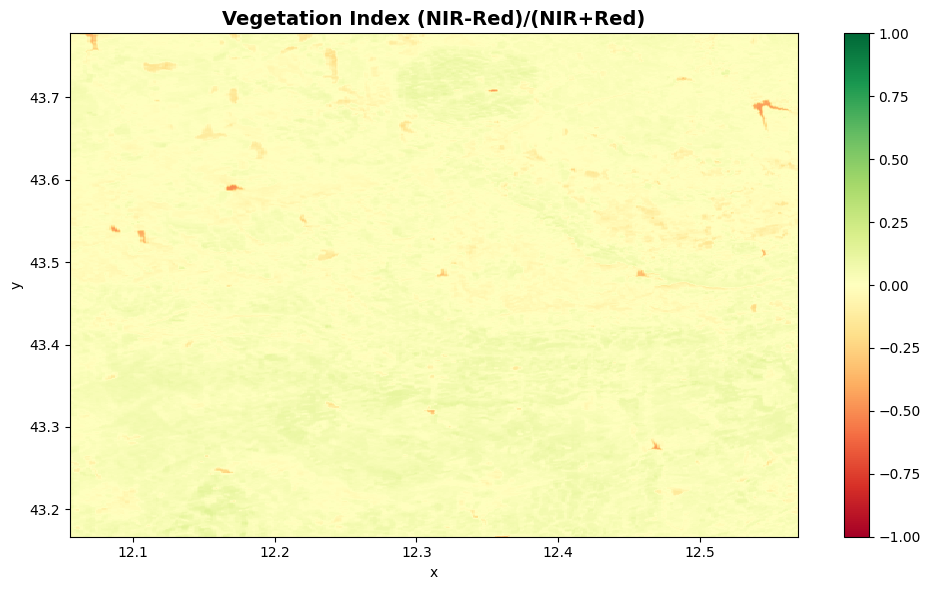


✅ Index calculation complete!


In [21]:
# Use Case 1: Calculate NDVI-like index (using two bands)
print("Use Case 1: Calculate Vegetation Index")
print("=" * 80)

# Get two bands (for demo purposes)
red_band = band_data['Band 6 (560nm)'][0, 1000:1500, 2000:2500]
nir_band = band_data['Band 11 (709nm)'][0, 1000:1500, 2000:2500]

# Calculate a simple index
index = (nir_band - red_band) / (nir_band + red_band + 1e-8)

print(f"Index shape: {index.shape}")
print(f"Index range: [{float(index.min()):.4f}, {float(index.max()):.4f}]")
print(f"Index mean: {float(index.mean()):.4f}")

# Visualize
plt.figure(figsize=(10, 6))
index.plot(cmap='RdYlGn', vmin=-1, vmax=1)
plt.title('Vegetation Index (NIR-Red)/(NIR+Red)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✅ Index calculation complete!")

## 14. Summary

This notebook demonstrated:

1. ✅ Opening EOPF Zarr datasets with rioxarray
2. ✅ Accessing geospatial metadata (CRS, bounds, resolution)
3. ✅ Data slicing and subsetting
4. ✅ Visualization with matplotlib
5. ✅ Working with multiple bands
6. ✅ Reprojection and clipping
7. ✅ Performance best practices
8. ✅ Common analysis workflows

## Key Takeaways

- **EOPFZARR + rioxarray** provides a powerful combination for working with EOPF Zarr datasets
- **Always open specific subdatasets** for best performance
- **Use lazy evaluation** with Dask chunks for memory efficiency
- **Full xarray functionality** available for analysis and visualization

## Resources

- [rioxarray Documentation](https://corteva.github.io/rioxarray/)
- [xarray Documentation](https://docs.xarray.dev/)
- [GDAL Documentation](https://gdal.org/)
- [EOPFZARR GitHub](https://github.com/EOPF-Sample-Service/GDAL-ZARR-EOPF)